In [1]:
IPOLCONFIG = "ipol.config"
CONFIG = "config.dat"
VETOFN = "../constrained_params2.py"
QUIET = False
import glob
IPOLPATH = "Polys"
IPOLFILES = glob.glob(IPOLPATH+"/*")
print IPOLFILES

LIMITS = None 
EXTRAPARAMS = None
import sys

class SuperSignalGenerator(object):
    """
    Object holding patches.
    """
    def __init__(self, ifiles, expression, limitfile=None, extraparams=[], ipolconf={}):
        from collections import OrderedDict
        self._boxdict   = OrderedDict()
        self._centerdict = OrderedDict()
        self._generators = []
        self._ipolconf = ipolconf
        self._limits=OrderedDict()
        self._fixed=OrderedDict()
        self._currentpatch=None

        for f in ifiles:
            s=SignalGenerator(f, expression, extraparams=extraparams, ipolconf=ipolconf)
            self._generators.append(s)
            self._boxdict[tuple(s.box)]       = s
            self._centerdict[tuple(s.center)] = s
        self._pnames   = s.pnames
        self._npatches = len(ifiles)
        self.calcLimits()

        if limitfile is not None:
            print "Set limits in SigGen from",limitfile
            self.setLimits(limitfile)
            self.removeRedundantGenerators()
            print self._limits


    def removeRedundantGenerators(self):
        remove = []
        for num, pname in enumerate(self._limits.keys()):
            a=self._limits[pname][0]
            b=self._limits[pname][1]
            # print "Testing %s in [a=%f, b=%f]"%(pname, a,b)
            for  num2, box in enumerate(self._boxdict.keys()):
                c=box[num][0]
                d=box[num][1]
                if d < a or c>b:
                    # print "Removing c=%f d=%f"%(c,d)
                    if not num2 in remove:
                        remove.append(num2)

        for pname, fval in self._fixed.iteritems():
            tidx = self.pnames.index(pname)
            # print "Testing %s=%f [%f,%f]"%(pname, fval, 0.9*fval, 1.1*fval)
            for  num2, box in enumerate(self._boxdict.keys()):
                c=box[tidx][0]
                d=box[tidx][1]
                if 1.1*fval < c or 0.9*fval >d :
                    # print "Removing c=%f d=%f"%(c,d)
                    if not num2 in remove:
                        remove.append(num2)
        self._generators=[x for num, x in enumerate(self._generators) if not num in remove]
        self._boxdict    = {key : self._boxdict[key]    for num, key in enumerate(self._boxdict.keys())    if not num in remove}
        self._centerdict = {key : self._centerdict[key] for num, key in enumerate(self._centerdict.keys()) if not num in remove}
        # for num, key in enumerate(self._boxdict.keys()):
            # if not num in remove:
                # # self._boxdict[


    def calcLimits(self):
        pnames = self._generators[0].pnames
        boxes = self._boxdict.keys()

        PMIN, PMAX = [], []

        for i, pname in enumerate(pnames):
            pmin = [b[i][0] for b in boxes]
            pmax = [b[i][1] for b in boxes]
            self._limits[pname] = ( min(pmin), max(pmax) )

    def setLimits(self, fname):
        import professor2 as prof
        limits, fixed = prof.read_limitsandfixed(fname)
        for k, v in limits.iteritems():
            self._limits[k]=(v[0], v[1])
            # self._limits[k][1]=v[1]

        for k, v in fixed.iteritems():
            for g in self._generators:
                g.fixParam(k, float(v))
            self._fixed[k] = float(v)

    def distance(self, A, B):
        import math
        return math.sqrt(sum([ (A[i]-B[i])*(A[i]-B[i]) for i in xrange(len(A))]))

    def pInBOX(self, P, box):
        for pname, p in P.iteritems():
            pidx = self._pnames.index(pname)
            # print min(box[pidx]), p, max(box[pidx])
            if p<min(box[pidx]) or p>max(box[pidx]):
                return False
        return True

    def pInMassBox(self, P, box):
        for pname, p in P.iteritems():
            pidx = self._pnames.index(pname)
            #print min(box[pidx]), p, max(box[pidx])
            #print type(pname), pname, (pname == "mdm")
            if p>min(box[pidx]) and p<max(box[pidx]) and pname == "mdm":
                return True
        return False

    def val(self, P, nbin):
        if len(self._generators)==1:
            return self._generators[0].val(P, nbin)
        else:
            # check boxes first
            box=None
            for b in self._boxdict.keys():
                #print "Test", b
                if self.pInBOX(P, b):
                    box = b
                    #print "p in box"
                    break

            if box is None:
                distances={}
                for c in self._centerdict.keys():
                    distances[self.distance([P[x] for x in self.pnames if x not in self._fixed.keys()], c)] = c
                #print distances
                #print P.keys()
                #print min(distances)
                
                winner = min(distances)   
                # return None
                if "mdm" in P.keys():
                    box2 = None
                    for d in self._boxdict.keys():
                        #print "Test", d
                        if self.pInMassBox(P, d):
                            #print "made it here"
                            box2 = d
                            
                            
                    
                    if box2 is None:
                        print ("Polynomials are extrapolating, they haven't been trained for this!\r")
                        self._currentpatch=self._centerdict[distances[winner]]
                        return self._centerdict[distances[winner]].val(P, nbin)
                    else:
                        self._currentpatch=self._boxdict[box2]
                        return self._boxdict[box2].val(P, nbin)

                else:
                    
                    print ("Polynomials are extrapolating, they haven't been trained for this loop 1\r!")
                    self._currentpatch=self._centerdict[distances[winner]]
                    return self._centerdict[distances[winner]].val(P, nbin)


            else:
                #print "Found", P , "in box #", self._boxdict.keys().index(box) , "(", box, ")"
                self._currentpatch=self._boxdict[box]
                return self._boxdict[box].val(P, nbin)

    @property
    def nActiveParams(self):
        return len(self._pnames) - len(self._fixed.keys())

    @property
    def pnames(self):
        return self._pnames

    @property
    def limits(self):
        return self._limits

    @property
    def npatches(self):
        return self._npatches

    def xmin(self, nb):
        # Assuming that all bits are consistent, simply pick up the binning from one of the generators
        return self._generators[0].xmin(nb)
    
    def xmax(self, nb):
        # Assuming that all bits are consistent, simply pick up the binning from one of the generators
        return self._generators[0].xmax(nb)

class SignalGenerator(object):
    """
    Class for single patch.
    """
    def __init__(self, ifile, expression, extraparams=[], fixparams=[], ipolconf={}):
        self._ifile = ifile
        self._expr = expression
        self._extraparams = extraparams
        self._fixed = {}
        self._ipolconf=ipolconf
        import re
        self._terms      = re.findall(r"[\w'\/]+", expression)
        self._operations = re.findall(r"[-+]", expression)
        # import sympy
        # self._vars = [sympy.Symbol(x.split("/")[-1]) for x in self._terms]
        self._ihistos = {}

        from collections import OrderedDict
        self._center=OrderedDict()
        self._box=OrderedDict()
        self.load()

    def __str__(self):
        return "Signalgenerator"+str(self._box)


    def load(self):
        import professor2 as prof
        IHISTOS, META = prof.read_ipoldata(self._ifile)
        self._pnames = META["ParamNames"].split()
        self._active = [p for p in self._pnames]
        PMIN = map(float, META["MinParamVals"].split())
        PMAX = map(float, META["MaxParamVals"].split())

        center = tuple([PMIN[i] + 0.5*(PMAX[i]-PMIN[i]) for i in xrange(len(PMIN))])
        box    = tuple([(PMIN[i], PMAX[i])              for i in xrange(len(PMIN))])

        for num, p in enumerate(self._pnames):
            self._center[p] = center[num]
            self._box[p]    = box[num]


        for k, v in IHISTOS.iteritems():
            # Keep the old way for now
            if self._ipolconf == {}:
                if k in self._terms:
                    if len(self._terms)>1:
                        # First figure out which parameter (indices) to use for this histo
                        praw=k.split("/")[-1].split("_") # A list of params
                        print praw, self._pnames
                        nparams = len(set(praw)) # Check for duplicates, e.g. ['cpi', 'cpi']
                        if nparams==1:
                            if praw[0] in self._active:
                                useparams=[self._pnames.index(praw[0])] # Find the correct index of the parameter
                            else:
                                print "Eieieie"
                                useparams=[self._pnames.index(x) for x in self._pnames]
                        else:
                            if nparams>len(praw):
                                print "Error this structure or parameters, %s, is no implemented, ignoring"%praw
                                continue
                            else:
                                useparams=[self._pnames.index(x) for x in praw if x in self._pnames]
                        for p in self._extraparams:
                            if not p in useparams:
                                useparams.append(self._pnames.index(p))

                        # Now store a tuple (ihisto, paramindexlist to use)
                        self._ihistos[k]=(v, useparams)
                    else:
                        self._ihistos[k]=(v, [x for x in xrange(len(self._pnames))])
            else:
                self._ihistos[k]=(v, [self._pnames.index(p) for p in self._ipolconf[k]])

        # Sanity check to make sure user supplied the config stuff correctly
        for t in self._terms:
            if not t in self._ihistos.keys():
                print "Config error, requested term %s not found in ipol"%t
                print "Please choose from the following:"
                for k in IHISTOS.keys():
                    print k
                sys.exit(1)

        del IHISTOS

    def fixParam(self, pname, value):
        self._fixed[pname]=value

    def val(self, dP, nbin):
        if len(self._fixed.keys())>0:
            for k, v in self._fixed.iteritems():
                dP[k] =v
        P=[dP[pname] for pname in self.pnames]

        # for n in self.pnames:
            # print n, dP[n]

        from math import exp
        I, pidx = self._ihistos[self._terms[0]]
        logv = I.bins[nbin].val([P[i] for i in pidx])
        try:
            v = exp(logv)#I.bins[nbin].val([P[i] for i in pidx]))
        except OverflowError:
            print "Could not evaluate exp(%f), for bin %i returning None"%(logv, nbin), "at", [P[i] for i in pidx]
            return None
        for num, o in enumerate(self._operations):
            I, pidx = self._ihistos[self._terms[num+1]]
            logtemp = I.bins[nbin].val([P[i] for i in pidx])
            try:
                temp=exp(logtemp)
            except OverflowError:
                print "Could not evaluate exp(%f), at point %s, returning None"%(logv, P)
                return None
            if o == "+":
                v+=temp
            elif o=="-":
                v-=temp
            else:
                print "Operation '%s' not permitted, exiting"%o
                import sys
                sys.exit(1)
        return v

    @property
    def pnames(self):
        return self._pnames

    def xmin(self, nbin):
        I, pidx = self._ihistos[self._terms[0]]
        return I.bins[nbin].xmin
    
    def xmax(self, nbin):
        I, pidx = self._ihistos[self._terms[0]]
        return I.bins[nbin].xmax

    @property
    def center(self):
        return self._center.values()

    @property
    def box(self):
        return self._box.values()

    @property
    def dim(self):
        return len(self._pnames)

# Import some prof stuff
import optparse, os, sys


if VETOFN:
    execfile(VETOFN)
    assert "constraint_vesc" in dir()
    VETOFN = constraint_vesc


## Config file is also mandatory
if CONFIG is None:
    print "Error, no config file for likelihood given, exiting"
    sys.exit(1)
    
## Load Professor and show the standard banner
import professor2 as prof
if not QUIET:
    print prof.logo


# Test if requested ipol files actually exist
IPOL_FULL=[]
for a in IPOLFILES:
    IPOL_FULL.append(a)
    if not os.path.exists(a):
        print "Error, ipol file %s does not exist"%a
        sys.exit(1)

    

# Parameterisation related stuff
ICNF={}
if IPOLCONFIG is not None:
    with open(IPOLCONFIG) as f:
        for line in f:
            l=line.strip()
            if len(l)==0 or l.startswith("#"):
                continue
            temp = l.split()
            histoname = temp[0]
            useparams = temp[1:]
            ICNF[histoname] = useparams


SIGNALS={}
USEBINS={}
with open(CONFIG) as f:
    for line in f:
        l=line.strip()
        if l.startswith("#"):
            continue
        kraw, expr = l.split(":")
        kraw=kraw.strip()
        if "#" in kraw:
            k, usebinsraw=kraw.split("#")
            usebins=map(int, usebinsraw.split("-"))
            USEBINS[k] = usebins
        else:
            k=kraw
            print "set the bins you want to read in your config file!"
            sys.exit(1)
        print IPOL_FULL
        SIGNALS[k] = SuperSignalGenerator(IPOL_FULL, expr.strip(), LIMITS, EXTRAPARAMS, ICNF)


activeparameters=SIGNALS[SIGNALS.keys()[0]].pnames
PMIN=[SIGNALS[SIGNALS.keys()[0]].limits[x][0] for x in activeparameters]
PMAX=[SIGNALS[SIGNALS.keys()[0]].limits[x][1] for x in activeparameters]


print PMIN
print PMAX
    
PP = {}
for x in activeparameters:
    just_above_min = SIGNALS[SIGNALS.keys()[0]].limits[x][0] + 0.05* SIGNALS[SIGNALS.keys()[0]].limits[x][0]
    PP[x]=just_above_min

#PP['halo_rhochi']=0.4
#PP['halo_v0']= 220.0
#PP['halo_vesc']=544.0
#PP['halo_k']=2.0


N_ipol, ibins_xmin = {}, {}
for datakey, signal in SIGNALS.iteritems():
    N_ipol[datakey]     = []
    ibins_xmin[datakey] = []
    if VETOFN and  "mdm" in activeparameters and "halo_vesc" in activeparameters:
        Emax = VETOFN(PP["mdm"], datakey, PP["halo_vesc"]+PP["halo_v0"])
    elif VETOFN and  "mdm" in activeparameters:
        Emax = VETOFN(PP["mdm"], datakey)
    else:
        Emax = float("inf")
    print "here", usebins
    for nb in xrange(usebins[1]-usebins[0]):
        nb+=usebins[0]
        if Emax < signal.xmin(nb):
            #print 'if1'
            N_ipol[datakey].append(0)
        else:
            v=signal.val(PP,nb)
            if v is not None:
                N_ipol[datakey].append(signal.val(PP,nb))

            else:
                print "Current point:", PP
                print signal._currentpatch
                print "Maybe use/adjust --limts?"
                
print N_ipol

['Polys/ipol_All_sub2', 'Polys/ipol_All_sub0', 'Polys/ipol_All_sub4', 'Polys/ipol_All_sub6', 'Polys/ipol_All_sub5', 'Polys/ipol_All_sub13', 'Polys/ipol_All_sub17', 'Polys/ipol_All_sub14', 'Polys/ipol_All_sub7', 'Polys/ipol_All_sub15', 'Polys/ipol_All_sub8', 'Polys/ipol_All_sub3', 'Polys/ipol_All_sub16', 'Polys/ipol_All_sub18', 'Polys/ipol_All_sub9', 'Polys/ipol_All_sub1', 'Polys/ipol_All_sub11', 'Polys/ipol_All_sub10', 'Polys/ipol_All_sub12']

Visit us on http://professor.hepforge.org/
Please cite arXiv:0907.2973 [hep-ph]
                                          2019-07-08 19:34:35
 ______           __                            _____ _____
 | ___ \         / _|                          |_   _|_   _|
 | |_/ / __ ___ | |_ ___  ___ ___  ___  _ __     | |   | |
 |  __/ '__/ _ \|  _/ _ \/ __/ __|/ _ \| '__|    | |   | |
 | |  | | | (_) | ||  __/\__ \__ \ (_) | |      _| |_ _| |_
 |_|  |_|  \___/|_| \___||___/___/\___/|_|     |_____|_____|

 Andy Buckley, Holger Schulz                     

In [2]:
def ret_ipol(PP):
    log_N_ipol, N_ipol, ibins_xmin = {}, {}, {}
    for datakey, signal in SIGNALS.iteritems():
        log_N_ipol[datakey]= []
        N_ipol[datakey]     = []
        ibins_xmin[datakey] = []
        if VETOFN and  "mdm" in activeparameters and "halo_vesc" in activeparameters:
            Emax = VETOFN(PP["mdm"], datakey, PP["halo_vesc"]+PP["halo_v0"])
        elif VETOFN and  "mdm" in activeparameters:
            Emax = VETOFN(PP["mdm"], datakey)
        else:
            Emax = float("inf")
        for nb in xrange(usebins[1]-usebins[0]):
            nb+=usebins[0]
            if Emax < signal.xmin(nb):
                #print 'if1'
                N_ipol[datakey].append(0)
                log_N_ipol[datakey].append(-200)
            else:
                v=signal.val(PP,nb)
                if v is not None:
                    N_ipol[datakey].append(signal.val(PP,nb))
                    log_N_ipol[datakey].append(log(N_ipol[datakey][-1]))
                else:
                    print "Current point:", PP
                    print signal._currentpatch
                    print "Maybe use/adjust --limts?"
                
    return N_ipol

In [3]:
usebins[1]-usebins[0]

20

In [6]:
def plot_ipol(mdm=SIGNALS[SIGNALS.keys()[0]].limits["mdm"][0],
              c1=SIGNALS[SIGNALS.keys()[0]].limits["c1"][0],
              c6=SIGNALS[SIGNALS.keys()[0]].limits["c6"][0],
              c10=SIGNALS[SIGNALS.keys()[0]].limits["c10"][0]):
    import numpy as np
    import matplotlib.pyplot as plt
    PP = {"mdm":mdm, "c1":c1, "c6":c6, "c10":c10}

    
    for datakey, signal in SIGNALS.iteritems():

        Eleft = {datakey:[]}
        Eright = {datakey:[]}
        for nb in xrange(usebins[1]-usebins[0]):
            nb+=usebins[0]
            Eleft[datakey].append(signal.xmin(nb))
            Eright[datakey].append(signal.xmax(nb))
    
        #print datakey
        plt.bar(Eleft[datakey],ret_ipol(PP)[datakey],
                 (np.asarray(Eright[datakey][:])
                  -np.asarray(Eleft[datakey][:])), 
                 color = 'white', linewidth=3.0, edgecolor = 'black',
                linestyle='dashed')

        plt.title(datakey.split('/')[2])
        plt.ylabel('Counts')
        plt.xlabel('Recoil Energy [keV]')

    #plt.savefig(pdfpath)
    plt.show()
    return 

Polynomials are extrapolating, they haven't been trained for this!
Polynomials are extrapolating, they haven't been trained for this!
Polynomials are extrapolating, they haven't been trained for this!
Polynomials are extrapolating, they haven't been trained for this!
Polynomials are extrapolating, they haven't been trained for this!
Polynomials are extrapolating, they haven't been trained for this!
Polynomials are extrapolating, they haven't been trained for this!
Polynomials are extrapolating, they haven't been trained for this!
Polynomials are extrapolating, they haven't been trained for this!
Polynomials are extrapolating, they haven't been trained for this!
Polynomials are extrapolating, they haven't been trained for this!
Polynomials are extrapolating, they haven't been trained for this!
Polynomials are extrapolating, they haven't been trained for this!
Polynomials are extrapolating, they haven't been trained for this!
Polynomials are extrapolating, they haven't been trained for t

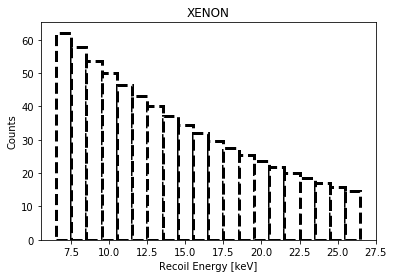

In [7]:
plot_ipol(2.0,-4.0)